In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 24.3 MB/s eta 0:00:00


In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [3]:
# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [5]:
# Config
SUB_FILE_NAME = "val12-1"
SAVE_SUB = False
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SAVE_DF = False
SAVE_DF_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/Val_20230429")

# データ読み込み

In [6]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")

# 特徴抽出後のデータ
umap_basic_train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_train.pkl")
umap_basic_test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_test.pkl")
train_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_sentinel_minmaxDiff.pkl")
test_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_sentinel_minmaxDiff.pkl")
train_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_train_landsat2_2000to2020.pkl")
test_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_test_landsat2_2000to2020.pkl")
train_landsat_norm = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230430_train_landsat3_normalized.pkl")
test_landsat_norm = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230430_test_landsat3_normalized.pkl")
train_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230430_train_landsat4_minmax.pkl")
test_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230430_test_landsat4_minmax.pkl")

train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [7]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

## 対数変換

In [8]:
train[f"log_cover"] = np.log1p(train["cover"])

## データの日付とLandsat画像の日付の差

In [9]:
# 学習データの時期の日付は全部15日にする
train["date"] = train["year"].astype(int).astype(str) + "/" + train["month"].astype(int).astype(str) + "/15"
train["date"] = pd.to_datetime(train["date"])
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,log_cover,date
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10,0.048790,2011-09-15
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13,0.545227,2009-07-15


In [10]:
train["Date_Acquired"] = pd.to_datetime(train["Date_Acquired"], format="%Y%m%d")
train["Date_Acquired"].head(2)

0   2012-01-18
1   2009-07-06
Name: Date_Acquired, dtype: datetime64[ns]

In [11]:
train["date_diff"] = (train["Date_Acquired"] - train["date"]) / dt.timedelta(days=1)
train["date_diff"].head(2)

0    125.0
1     -9.0
Name: date_diff, dtype: float64

## 特徴抽出後のデータを結合

In [12]:
# いらんデータ消しておく
cols_landsat_2000to2020 = [col for col in train_landsat_2000to2020.columns if not "MINMAX" in col]
train_landsat_2000to2020 = train_landsat_2000to2020[cols_landsat_2000to2020]
test_landsat_2000to2020 = test_landsat_2000to2020[cols_landsat_2000to2020]

In [13]:
print(train.shape)
print(train_landsat_minmax.shape)
print(test.shape)
print(test_landsat_minmax.shape)
train_landsat_minmax.head(2)

(14140, 3467)
(14140, 100)
(4039, 3463)
(4039, 100)


,MINMAX_CTVI_mean,MINMAX_CTVI_std,MINMAX_PPR_mean,MINMAX_PPR_std,MINMAX_TIRS2_mean,MINMAX_TIRS2_std,MINMAX_EVI_mean,MINMAX_EVI_std,MINMAX_SIPI2_mean,MINMAX_SIPI2_std,...,MINMAX_MCARI2_mean,MINMAX_MCARI2_std,MINMAX_BWDRVI_mean,MINMAX_BWDRVI_std,MINMAX_MCARI1_mean,MINMAX_MCARI1_std,MINMAX_SWIR2_mean,MINMAX_SWIR2_std,MINMAX_Ferric_Oxides_mean,MINMAX_Ferric_Oxides_std
0,0.134025,0.111810,0.080669,0.086960,0.339952,0.359248,0.042444,0.058448,1.817571,2.293036,...,0.973567,0.848198,0.028040,0.035760,11.012710,19.343378,1.181849,1.944656,0.056972,0.049894
1,0.035624,0.047987,0.046483,0.045414,0.318083,0.318512,0.187296,0.193427,4.727555,6.033570,...,0.258074,0.266281,0.045798,0.048732,21.390165,24.260161,0.475902,0.772107,0.048084,0.053776


In [14]:
train = train.join([
    umap_basic_train,
    train_sentinel,
    train_landsat_minmax,
    train_landsat_2000to2020,
    train_landsat_norm,
])
test = test.join([
    umap_basic_test,
    test_sentinel,
    test_landsat_minmax,
    test_landsat_2000to2020,
    train_landsat_norm,
])
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,NLI_norm,NormG_norm,NormR_norm,PPR_norm,PSNDc2_norm,RDVI_norm,IF_norm,SLAVI_norm,SIPI2_norm,VARIgreen_norm
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-1.451049,0.475077,0.296024,-1.109615,-0.750047,-0.052587,0.127271,-0.406854,0.116049,-0.049049
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,1.864528,-3.654105,-1.126482,2.711313,5.444383,9.581726,12.557637,1.335754,-4.261068,0.143220


In [15]:
umap_basic_train.head()

,dim0,dim1,temp_monthly
0,1.788618,6.597842,27.9
1,-10.111396,6.170877,29.2
2,21.165592,6.679852,25.3
3,-6.996612,9.728025,16.7
4,-6.822807,9.109682,16.7


## 使用する特徴量

In [16]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
# cols_landsat = train.columns.to_list()[25:88]
cols_landsat = ["sunAzimuth", "sunElevation", "Landsat_num", "date_diff"]
cols_landsat_2000to2020 = train_landsat_2000to2020.columns.to_list()
cols_landsat_minmax = train_landsat_minmax.columns.to_list()
cols_landsat_norm = train_landsat_norm.columns.to_list()

cols_sentinel = train.columns.to_list()[88:313]
cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_sentinel_minmax = train_sentinel.columns.to_list()

cols_umap = ["temp_monthly"]

cols_use =\
 cols_base +\
 cols_landsat_2000to2020 +\
 cols_landsat_minmax +\
 cols_landsat_norm +\
 ["log_cover"] # + cols_sentinel

cols_remove = [
    "YMD",
    "month",
    "Date_Acquired",
    "Landsat_StartTime",
    "PRODUCT_ID",
    "mesh20"
]
cols_use = [col for col in cols_use if not col in cols_remove]

# Landsatの関係なさそうな指標を抜く
cols_remove2_raw = [
    "NBR",
    "NBR2",
    "Alteration",
    "DSWI",
    "DSWI_5",
    "Fe3",
    "Ferric_Oxides",
    "Ferrous_Silicates",
    "Gossan"
]
cols_remove2 = []
for rm_word in cols_remove2_raw:
    cols_remove2 += [col for col in cols_use if rm_word in col]
cols_use = [col for col in cols_use if not col in cols_remove2]

# 重複を省く（一応）
cols_use = list(set(cols_use))

cols_use

['MINMAX_mCRIG_mean',
 'MED_Red_median',
 'MINMAX_CVI_mean',
 'MINMAX_Chlred_edge_mean',
 'MINMAX_NLI_mean',
 'MINMAX_BWDRVI_std',
 'MED_TIRS2_std',
 'MINMAX_NIR_mean',
 'SWIR1_norm',
 'coastal_dist',
 'MED_D678_500_median',
 'MINMAX_MCARI1_std',
 'MED_IF_median',
 'MINMAX_TSAVI_mean',
 'MINMAX_mCRIRE_mean',
 'MED_RDVI_median',
 'MED_DVIMSS_std',
 'MED_CRI550_median',
 'Cirededge_norm',
 'MED_MVI_median',
 'MCARI1_norm',
 'MED_Red_std',
 'MINMAX_MVI_mean',
 'MINMAX_BWDRVI_mean',
 'MED_Cirededge_median',
 'MINMAX_TIRS1_std',
 'MINMAX_CTVI_std',
 'MED_SWIR1_median',
 'MINMAX_PSNDc2_std',
 'MINMAX_IR550_std',
 'NormG_norm',
 'MED_GVMI_median',
 'MINMAX_SIPI2_std',
 'lon',
 'SIPI2_norm',
 'MED_Green_median',
 'MED_NLI_median',
 'GEMI_norm',
 'MED_AVI_std',
 'MINMAX_Chlred_edge_std',
 'MED_NormG_median',
 'MED_MCARI1_median',
 'MINMAX_IF_std',
 'MED_DVIMSS_median',
 'MED_GVMI_std',
 'river_area',
 'MINMAX_SLAVI_mean',
 'MINMAX_SIPI2_mean',
 'MINMAX_DVIMSS_std',
 'MED_IR550_median',
 'cover'

In [17]:
train = train[cols_use]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Columns: 239 entries, MINMAX_mCRIG_mean to MED_NormR_median
dtypes: float32(24), float64(215)
memory usage: 24.5 MB


In [18]:
cols_obj = ["cover", "log_cover"]
features = [col for col in cols_use if col not in cols_obj]
print("特徴量の数：", len(features))

特徴量の数： 237


In [19]:
corr = train[features].corr()
threshold = 0.98
drop_numeric_cols=[]
pair=[]
for col in features:
    # if col in cat_features:
    #     continue
    for i in range(len(corr)):
        if abs(corr[col].iloc[i]) >= threshold and col != features[i] :
            print(f"{col} and {features[i]} are highly correlated...") 
            if col not in pair:
                pair.append(col)
                pair.append(features[i])
                drop_numeric_cols.append(col) 
features = list(set(features)-set(drop_numeric_cols))
print(f"Dropping columns : {drop_numeric_cols}")
print("特徴量の数：", len(features))
del drop_numeric_cols
del pair

features

MINMAX_CVI_mean and MINMAX_Cigreen_mean are highly correlated...
lon and cold_sst are highly correlated...
MED_CVI_std and MED_Cigreen_std are highly correlated...
CVI_norm and Cigreen_norm are highly correlated...
CVI_norm and BWDRVI_norm are highly correlated...
cold_sst and lon are highly correlated...
cold_sst and sst_annual are highly correlated...
cold_sst and lat are highly correlated...
Cigreen_norm and CVI_norm are highly correlated...
Cigreen_norm and BWDRVI_norm are highly correlated...
MED_Cigreen_median and MED_CVI_median are highly correlated...
MINMAX_TIRS1_mean and MINMAX_TIRS2_mean are highly correlated...
MINMAX_Red_std and MINMAX_Green_std are highly correlated...
MINMAX_Green_mean and MINMAX_Red_mean are highly correlated...
MINMAX_Cigreen_mean and MINMAX_CVI_mean are highly correlated...
MED_Cigreen_std and MED_CVI_std are highly correlated...
MINMAX_Green_std and MINMAX_Red_std are highly correlated...
MED_BWDRVI_std and MED_PSNDc2_std are highly correlated...
MIN

['MINMAX_mCRIG_mean',
 'MED_Red_median',
 'MINMAX_Chlred_edge_mean',
 'MINMAX_NLI_mean',
 'MINMAX_BWDRVI_std',
 'MED_TIRS2_std',
 'MINMAX_NIR_mean',
 'SWIR1_norm',
 'coastal_dist',
 'MED_D678_500_median',
 'MINMAX_MCARI1_std',
 'MED_IF_median',
 'MINMAX_TSAVI_mean',
 'MINMAX_mCRIRE_mean',
 'MED_RDVI_median',
 'MED_DVIMSS_std',
 'Cirededge_norm',
 'MED_CRI550_median',
 'MED_MVI_median',
 'MCARI1_norm',
 'MED_Red_std',
 'MINMAX_MVI_mean',
 'MINMAX_BWDRVI_mean',
 'MED_Cirededge_median',
 'MINMAX_TIRS1_std',
 'MINMAX_CTVI_std',
 'MED_SWIR1_median',
 'MINMAX_PSNDc2_std',
 'MINMAX_IR550_std',
 'NormG_norm',
 'MED_GVMI_median',
 'MINMAX_SIPI2_std',
 'SIPI2_norm',
 'MED_Green_median',
 'MED_NLI_median',
 'GEMI_norm',
 'MED_AVI_std',
 'MINMAX_Chlred_edge_std',
 'MED_NormG_median',
 'MED_MCARI1_median',
 'MINMAX_IF_std',
 'MED_DVIMSS_median',
 'MED_GVMI_std',
 'river_area',
 'MINMAX_SLAVI_mean',
 'MINMAX_SIPI2_mean',
 'MINMAX_DVIMSS_std',
 'MED_IR550_median',
 'MED_NormG_std',
 'MINMAX_CI_std',


# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [20]:
# train_date = train[["year", "month"]].copy()

# def convert_int_into_str(x):
#     x_str = str(int(x))
#     if len(x_str)==1:
#         return "0" + x_str
#     return x_str

# train_date["month_str"] = train_date["month"].apply(convert_int_into_str)
# train_date["year_month"] = (train_date["year"].astype(int).astype(str) + train_date["month_str"]).astype(int)
# train_date.head()

In [21]:
# year_month = train_date["year_month"]
# cv = []

# val_idx1 = (year_month >= 200901)&(year_month <200907)
# train_idx1 = ~val_idx1
# cv.append([train_idx1, val_idx1])

# val_idx2 = (year_month >= 200910)&(year_month <200912)
# train_idx2 = ~val_idx2
# cv.append([train_idx2, val_idx2])

# val_idx3 = (year_month >= 201006)&(year_month <201009)
# train_idx3 = ~val_idx3
# cv.append([train_idx3, val_idx3])

# val_idx4 = (year_month >= 201010)&(year_month <201101)
# train_idx4 = ~val_idx4
# cv.append([train_idx4, val_idx4])

# val_idx5 = (year_month >= 201909)&(year_month <201910)
# train_idx5 = ~val_idx5
# cv.append([train_idx5, val_idx5])

In [22]:
def my_cross_val_predict(df, df_test, y_name=None, y_raw_name=None, params=None, features=None, cv=None, split=5, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    kfold = KFold(n_splits=split, shuffle=True, random_state=42)
    X = df[features].values
    y = df[y_name].values
    y_raw = df[y_raw_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    y_pred_val_all = np.zeros(len(y))
    y_pred_val_all[:] = np.nan

    for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]
        y_val_raw = y_raw[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            # lgb.early_stopping(200),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred_raw = model.predict(X_val)
        y_pred = np.expm1(y_pred_raw)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        print(np.average(y_pred))
        y_pred_val_all[val_idx] = y_pred
        # testデータ予測
        y_pred_test_raw = model.predict(X_test)
        y_pred_test = np.expm1(y_pred_test_raw)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / split)
        
        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val_raw, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val_raw, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['fair'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean, y_pred_val_all

In [23]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

##############################
● CV0
##############################
[500]	valid_0's fair: 0.00400447
[1000]	valid_0's fair: 0.00357068
[1500]	valid_0's fair: 0.00339213
[2000]	valid_0's fair: 0.00327723
0.1748251216411951


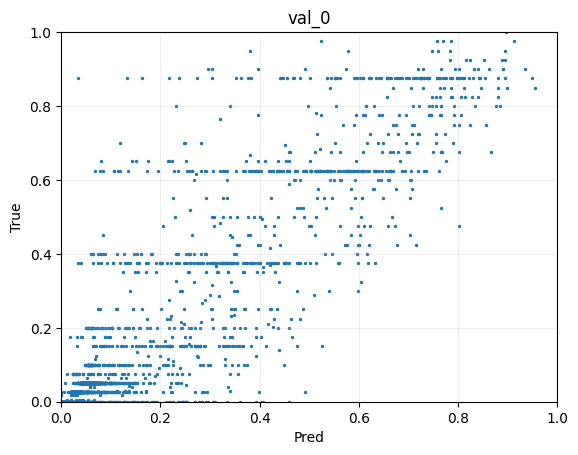

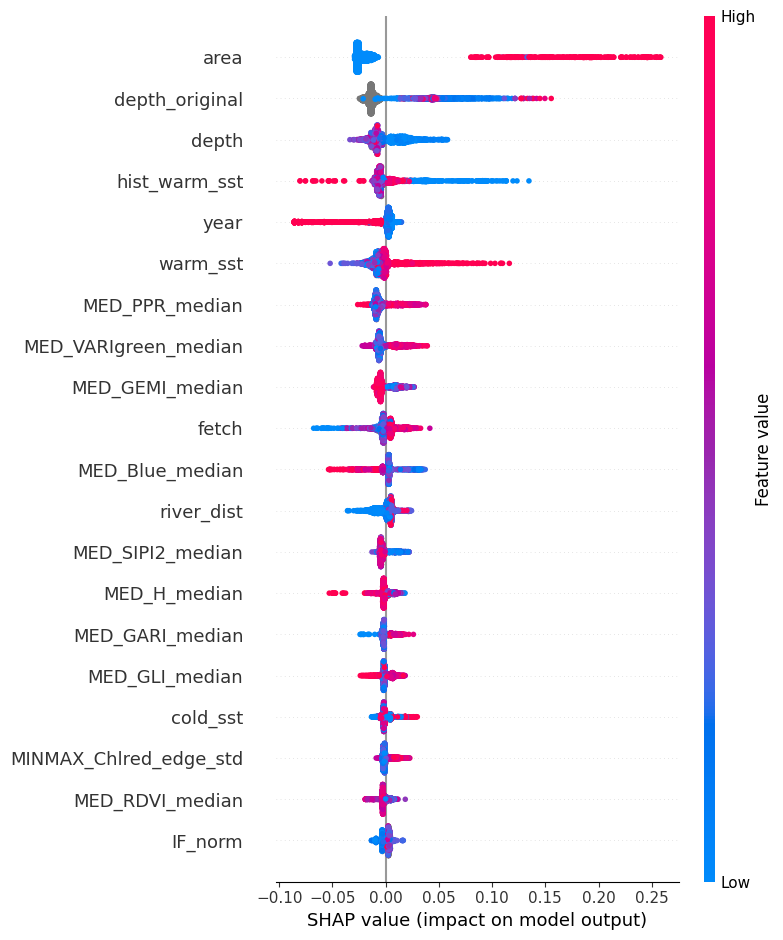

##############################
● CV1
##############################
[500]	valid_0's fair: 0.00408242
[1000]	valid_0's fair: 0.00365694
[1500]	valid_0's fair: 0.00344865
[2000]	valid_0's fair: 0.00330488
0.1766337119507949


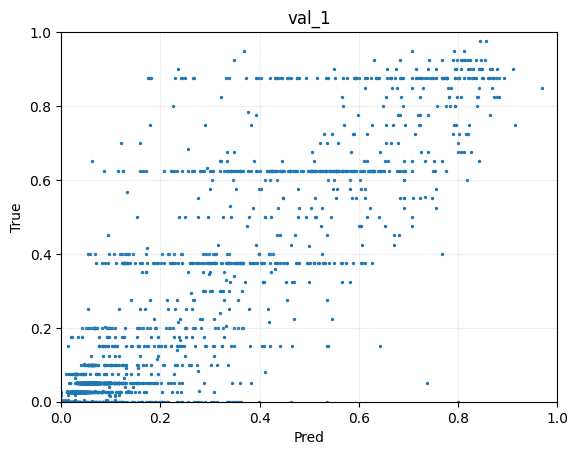

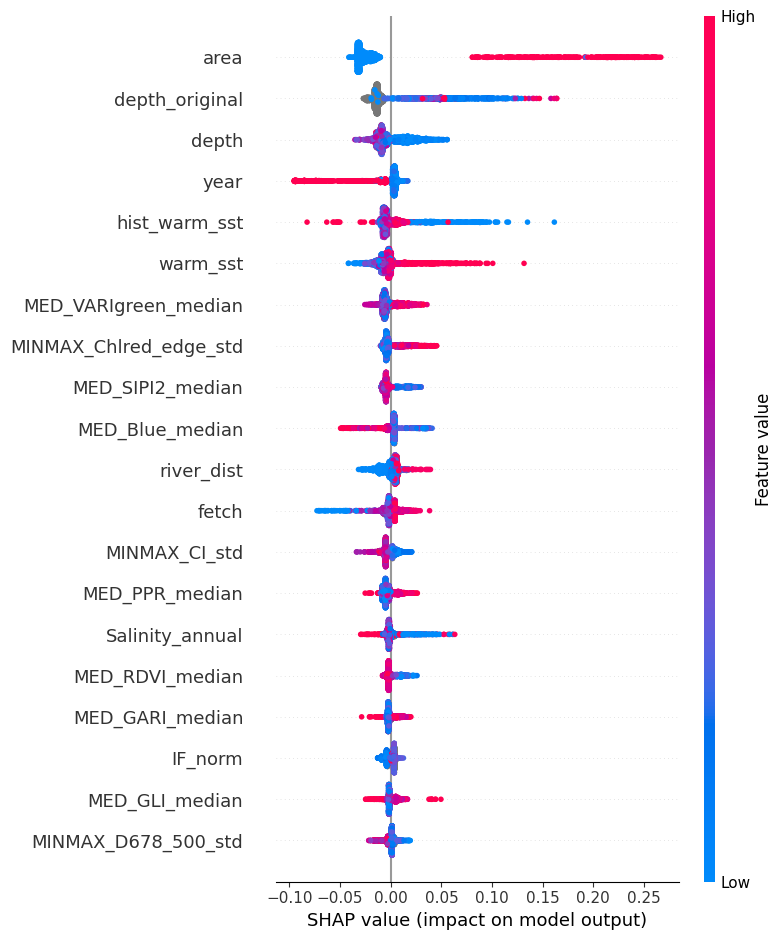

##############################
● CV2
##############################
[500]	valid_0's fair: 0.0040432
[1000]	valid_0's fair: 0.00364676
[1500]	valid_0's fair: 0.0034447
[2000]	valid_0's fair: 0.00331195
0.17840301978701956


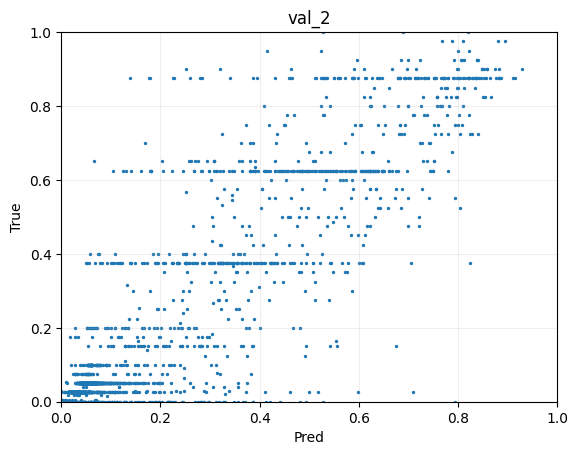

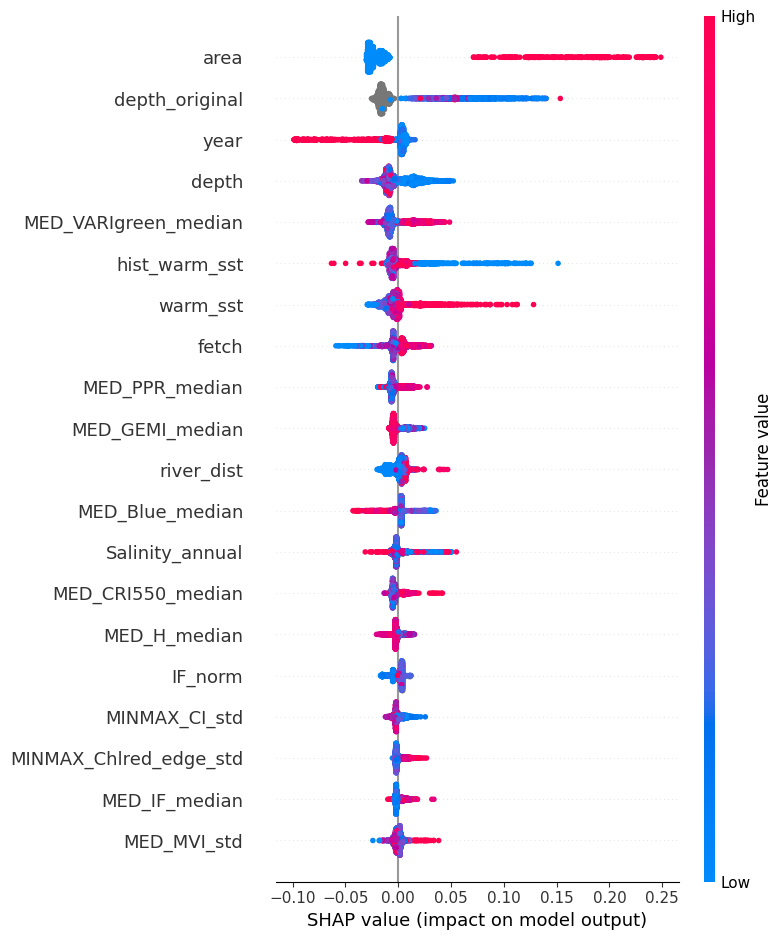

##############################
● CV3
##############################
[500]	valid_0's fair: 0.00385205
[1000]	valid_0's fair: 0.00339686
[1500]	valid_0's fair: 0.00317785
[2000]	valid_0's fair: 0.00305493
0.175989016251323


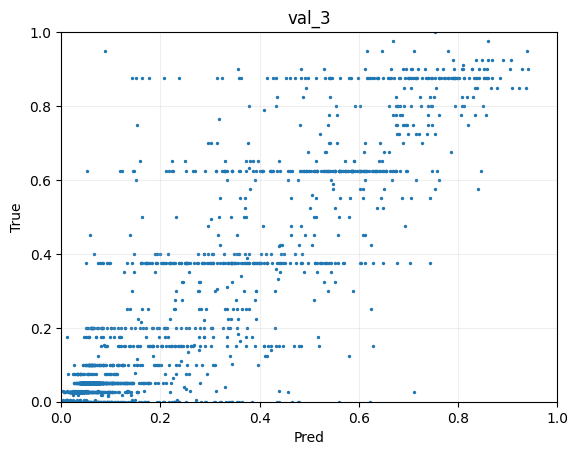

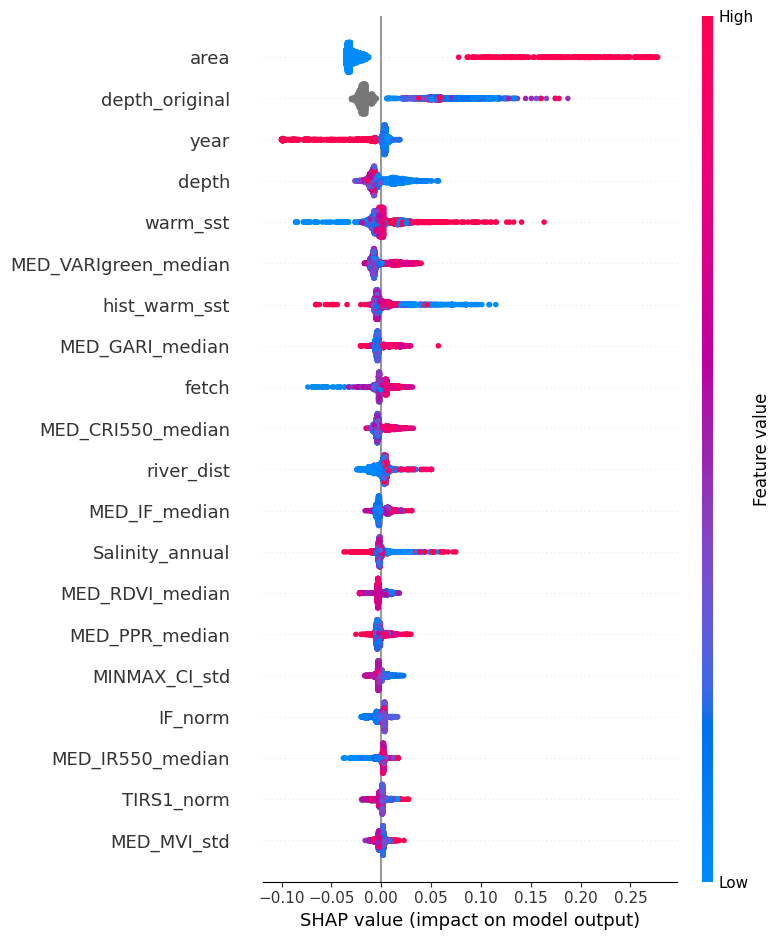

##############################
● CV4
##############################
[500]	valid_0's fair: 0.00433933
[1000]	valid_0's fair: 0.00386047
[1500]	valid_0's fair: 0.00362946
[2000]	valid_0's fair: 0.00346785
0.1761770734960885


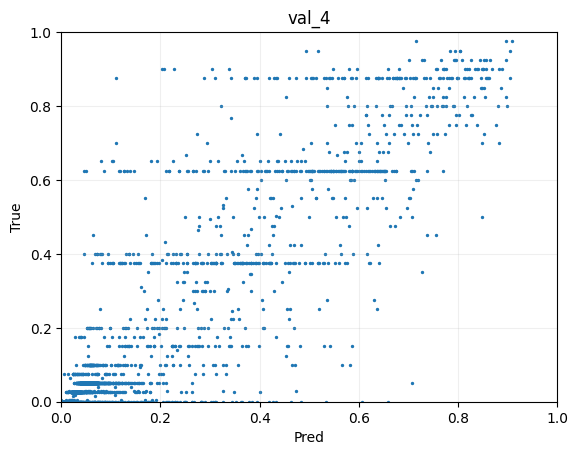

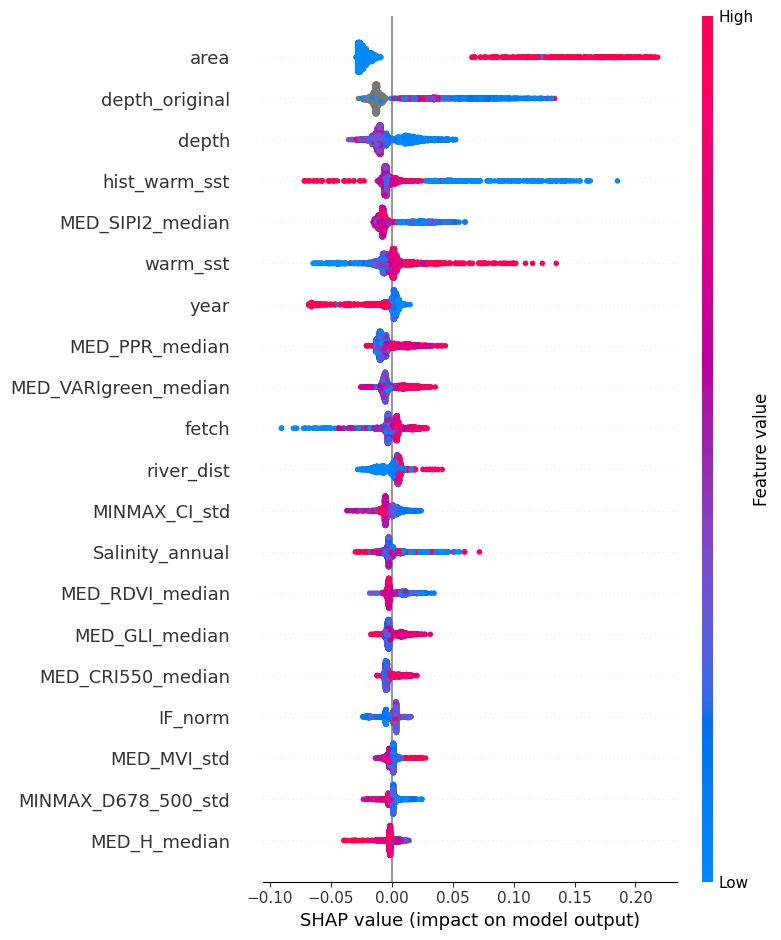

##############################
学習曲線
##############################


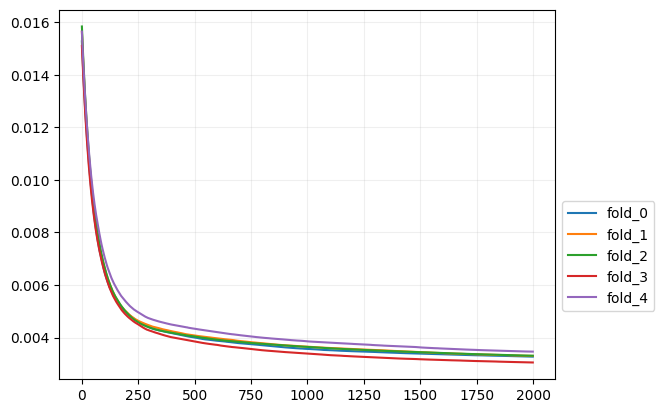

In [24]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'n_estimators': 2000,
    'learning_rate': 0.01,
    # 'num_leaves': 50,
    # 'colsample_bytree': 0.6,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_rmse, fi_df, y_test_pred, train["y_pred"] = my_cross_val_predict(train, test, y_name="log_cover", y_raw_name="cover", params=params, features=features)

CV0: 0.118
CV1: 0.121
CV2: 0.120
CV3: 0.115
CV4: 0.122
Average: 0.119


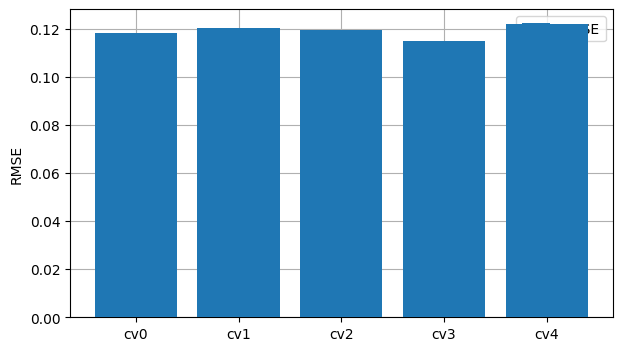

In [25]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 223)


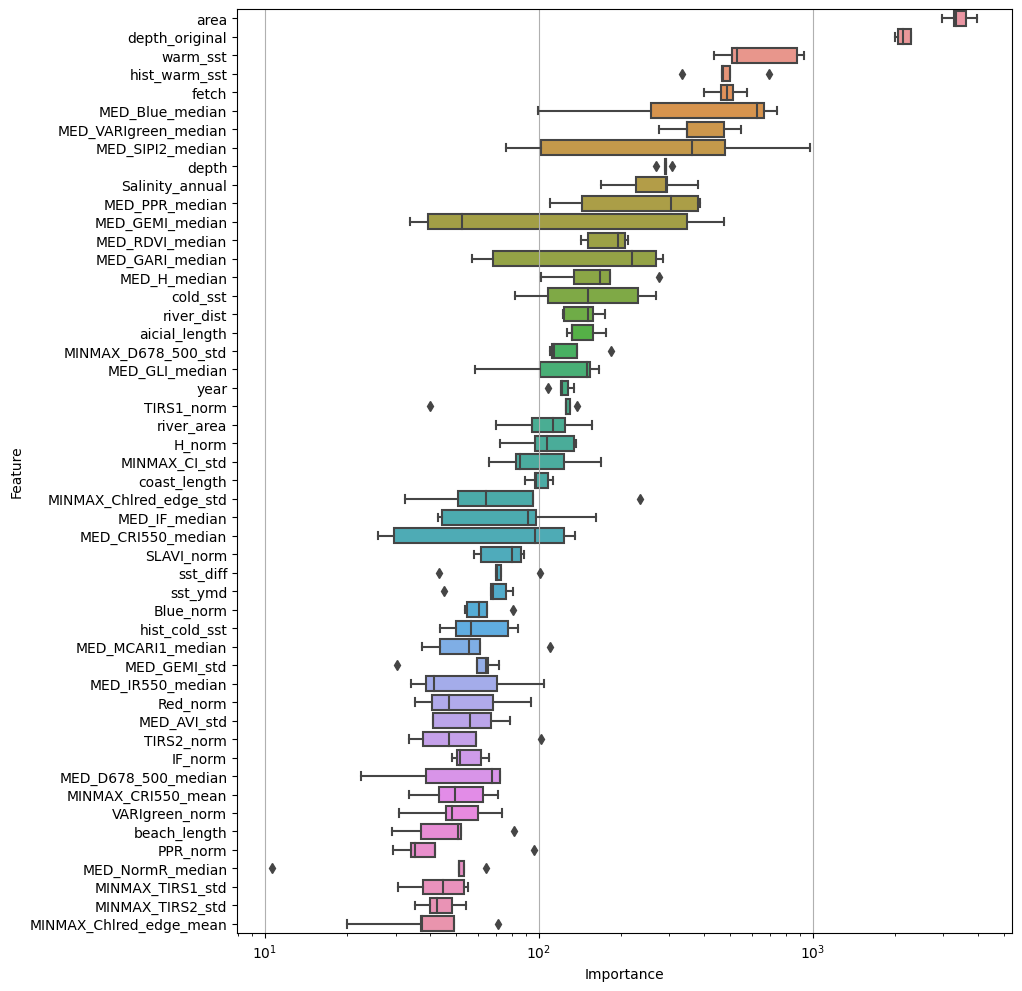

In [26]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [27]:
test_sub = pd.DataFrame(y_test_pred, columns=["pred"])
test_sub

,pred
0,0.167825
1,0.070582
2,0.548797
3,0.054503
4,0.164622
...,...
4034,0.123730
4035,0.042703
4036,0.439397
4037,0.081759


In [28]:
test_pred_mean = test_sub["pred"].mean()
test_pred_mean

0.18235188473693636

In [29]:
test_sub2 = test_sub.copy()
public_mean = 0.09088
# test_sub["pred"] = test_sub["pred"] * (public_mean / test_pred_mean)
test_sub2["pred"] -= (test_pred_mean - public_mean)
test_sub2["pred"] = np.clip(test_sub2["pred"].values, 0, 1)
test_sub2

,pred
0,0.076353
1,0.000000
2,0.457325
3,0.000000
4,0.073150
...,...
4034,0.032258
4035,0.000000
4036,0.347925
4037,0.000000


In [30]:
print("pred_最小値:", test_sub["pred"].min())
print("pred_最大値:", test_sub["pred"].max())
print("pred_平均値:", test_sub["pred"].mean())

pred_最小値: 0.0
pred_最大値: 0.8899732472687425
pred_平均値: 0.18235188473693636


In [31]:
print("●後処理後")
print("pred_最小値:", test_sub2["pred"].min())
print("pred_最大値:", test_sub2["pred"].max())
print("pred_平均値:", test_sub2["pred"].mean())

●後処理後
pred_最小値: 0.0
pred_最大値: 0.7985013625318061
pred_平均値: 0.10687161243385215


In [32]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)
    test_sub2.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}_mod.csv", header=False)

# 予測結果確認

In [33]:
def check_by_scatter(check_col):
    tmp1 = df_pred[train[check_col].isnull()]
    tmp2 = df_pred[~train[check_col].isnull()]
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.grid(alpha=0.2, color="gray")
    ax.scatter(tmp2["y_pred"], tmp2["cover"], s=6, label=f"NOT Null", alpha=0.5)
    ax.scatter(tmp1["y_pred"], tmp1["cover"], s=6, label=f"Null", alpha=0.5)
    ax.set_xlabel("Pred")
    ax.set_ylabel("True")
    ax.set_title(check_col)
    ax.legend()
    plt.show()

In [34]:
df_pred = train[["cover", "y_pred"]]
score = np.sqrt(mean_squared_error(train['cover'].values, train['y_pred'].values))
print(f"全体のRMSE: {score:.04f}")

全体のRMSE: 0.1191


●全体のRMSE (depth_originalがnull)
　データ数: 9721
　スコア: 0.0912

●全体のRMSE (depth_originalがnull以外)
　データ数: 4419
　スコア: 0.1646

テストデータでdepth_originalがnullの割合
　50.829%


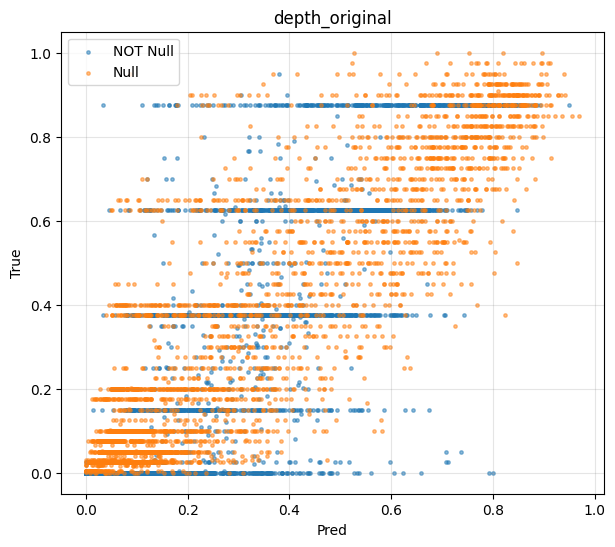

In [35]:
check_col = "depth_original"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [36]:
check_col = "Blue"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

KeyError: ignored

In [ ]:
check_col = "MED_AFRI1600"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [ ]:
check_col = "MAX_NormG__median"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [ ]:
check_col = "depth"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [ ]:
check_col = "Landsat_num"
tmp1 = df_pred[train[check_col]==7]
tmp2 = df_pred[train[check_col]==8]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}==7)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}==8)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}==7の割合")
print(f"　{(100*(test[check_col]==7).sum()/len(test)):.3f}%")

fig, ax = plt.subplots(figsize=(7, 6))
ax.grid(alpha=0.2, color="gray")
ax.scatter(tmp2["y_pred"], tmp2["cover"], s=6, label=f"Landsat_num==8", alpha=0.5)
ax.scatter(tmp1["y_pred"], tmp1["cover"], s=6, label=f"Landsat_num==7", alpha=0.5)
ax.set_xlabel("Pred")
ax.set_ylabel("True")
ax.set_title(check_col)
ax.legend()
plt.show()

In [ ]:
if SAVE_DF:
    train.to_pickle(SAVE_DF_DIR / f"train_predicted_{SUB_FILE_NAME}.pkl")